# Setup

In [1]:
"""
Add parent directorys to current path
"""
import os.path
import sys

"""
Add gym-hiring directory to current path. I believe this is needed
when referencing a pip "file:///" dependency.
"""
p = os.path.abspath('../')
if p not in sys.path:
    sys.path.insert(0, p)

import gym
import gym_hiring
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from experiments.utils import play_episode, plot_running_avg, running_avg

# Define Optimal Policy

In [10]:
class OptimalFairHiringPolicy:
    
    def __init__(self, gender_75):
        self.gender_75 = gender_75
    
    def select_action(self, obs, eps):
        gender = obs[0]
        prod_score = obs[1][0]
        
        # Hiring threshold is set to the 75th percentile of each
        # gender's Productivy Score.
        thresh = self.gender_75[gender]
            
        if prod_score >= thresh:
            return 1
        else:
            return 0
    
    def add_experience(self, prev_obs, action, reward, obs, done):
        pass
    
    def train(self, iters):
        pass

# Execute Optimal Policy

episode: 0, total reward: 58.00, eps: 1.000, avg reward last 100: 58.000
episode: 100, total reward: 49.00, eps: 0.397, avg reward last 100: 50.624
episode: 200, total reward: 48.00, eps: 0.346, avg reward last 100: 49.426
episode: 300, total reward: 60.00, eps: 0.319, avg reward last 100: 51.198
episode: 400, total reward: 36.00, eps: 0.302, avg reward last 100: 51.614
episode: 500, total reward: 55.00, eps: 0.288, avg reward last 100: 48.653
episode: 600, total reward: 60.00, eps: 0.278, avg reward last 100: 50.426
episode: 700, total reward: 35.00, eps: 0.270, avg reward last 100: 50.347
episode: 800, total reward: 53.00, eps: 0.263, avg reward last 100: 48.495
episode: 900, total reward: 51.00, eps: 0.000, avg reward last 100: 50.653

Total steps: 1,000
Avg cumulative reward: 50.043
Avg reward for last 100 episodes: 48.950


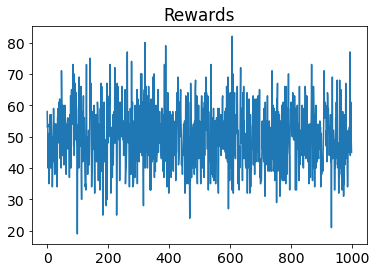

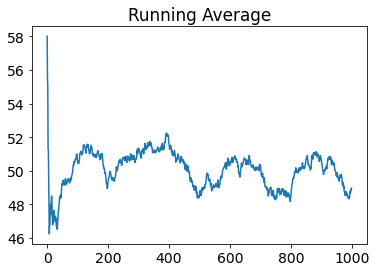

In [41]:
MEN_LOW = 1
MEN_HIGH = 9
WOM_LOW = 0
WOM_HIGH = 8

men_75th = (.75*(MEN_HIGH - MEN_LOW))+ MEN_LOW
wom_75th = (.75*(WOM_HIGH - WOM_LOW))+ WOM_LOW

def prod_score(cand_attr_values):
    gender = cand_attr_values[0]
    
    if gender == 1:
        score = np.random.randint(MEN_LOW, MEN_HIGH)
    else:
        score = np.random.randint(WOM_LOW, WOM_HIGH)
        
    return score

args = {'max_steps_per_episode': 100,
        'attr_probs': [[.5, .5]],
        'attr_names': ['gender'],
        'prod_score_fn': prod_score}

env = gym.make('hiring-v0', **args)
start_obs = env.reset()

model = OptimalFairHiringPolicy(gender_75=[wom_75th, men_75th])

N = 1000
totalrewards = np.zeros(N)

window = int(N/10)
for n in range(N):
    if n >= (N - window):
        eps = 0
    else:
        eps = 1.0/(n+1)**.2
    totalreward = play_episode(env, model, eps)
    totalrewards[n] = totalreward
    if n % window == 0:
        ravg = running_avg(totalrewards, n, window)
        print('episode: {:,}, total reward: {:,.2f}, eps: {:.3f}, avg reward last {:,}: {:.3f}'.format(
            n, totalreward, eps, window, ravg))

print('\nTotal steps: {:,}'.format(len(totalrewards)))
print('Avg cumulative reward: {:,.3f}'.format(totalrewards.mean()))
print('Avg reward for last {:,} episodes: {:,.3f}'.format(
    window, totalrewards[int(-1*(N/10)):].mean()))

plt.plot(totalrewards)
plt.title("Rewards")
plt.show()

plot_running_avg(totalrewards, window)

```
Computing expected reward per episode for optimal policy
--------------------------------------------------------
50% of time gender = male:
    75% of time the value will be lower than threshold => not hire => 0
    25% of time the value will be greater than threshold => hire => exp prod score of 7.5 => 7.5-5=2.5

50% of time gender = female:
    75% of time the value will be lower than threshold => not hire => 0
    25% of time the value will be greater than threshold => hire => exp prod score of 6.5 => 6.5-5=1.5
    
exp_rew_per_ep = (.5)((.75)(0) + (.25)(2.5)) + (.5)((.75)(0) + (.25)(1.5))
               = .5

Python code
-----------
>>> exp_rew_per_ep = (.5)*((.75)*(0) + (.25)*(2.5)) + (.5)*((.75)*(0) + (.25)*(1.5))
>>> 100*exp_rew_per_ep
```

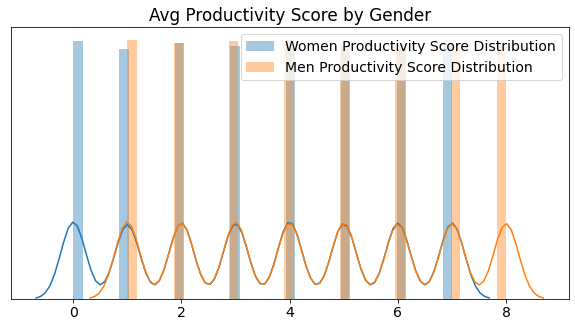

In [42]:
plt.rc('font', size=14)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.distplot(np.random.randint(WOM_LOW, WOM_HIGH, 100_000), ax=ax, label='Women Productivity Score Distribution')
sns.distplot(np.random.randint(MEN_LOW, MEN_HIGH, 100_000), ax=ax, label='Men Productivity Score Distribution')

ax.legend()
ax.set_title('Avg Productivity Score by Gender')
ax.set_yticks([])
pass

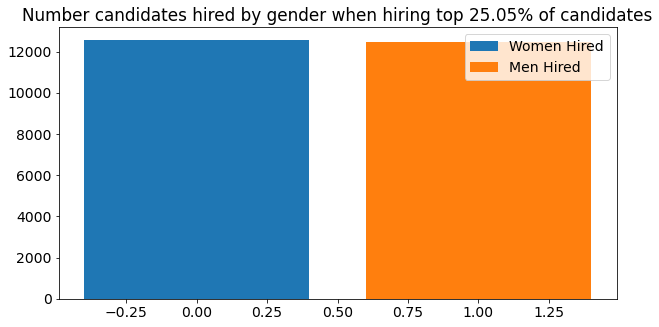

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.bar(0, env.attr_hire_counts[0][0], label='Women Hired')
ax.bar(1, env.attr_hire_counts[0][1], label='Men Hired')
ax.legend()
hire_rate = 100*np.sum(np.sum(env.action_episode_memory)) / (N*100)
ax.set_title('Number candidates hired by gender when hiring top {:.2f}% of candidates'.format(hire_rate))
pass

In [44]:
env.attr_counts

array([[50050, 49950]])

In [45]:
env.attr_hire_counts

array([[12564, 12484]])